In [1]:
import glob
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

### Getting the data

In [2]:
fnames = glob.glob("gas_prices_2020-08-01_2021-01-20_5%*")

# concat all data into one dataframe
l = []
for fname in fnames:
    df = pd.read_csv(fname, index_col=None, delimiter='\t')
    l.append(df)

df = pd.concat(l, axis=0, ignore_index=True)

# convert wei to gwei
df['gasPrice'] = df['gasPrice'] / 1_000_000_000

# remove last block num just in case (files are cut off)
df = df[df.blockNum != df.blockNum.max()]

df

,blockNum,txnID,gasPrice
0,10622444,0x889efe33c7d44428f01e45428eeb9362a9a1467e6865...,50.0
1,10622444,0xc3b15b99af8e163740cf9c5fe79b951f5018a04505c5...,150.0
2,10622444,0x32d3cffea7506342b88d5a309e23a1a85476d01bd8ad...,49.0
3,10622444,0x4e58f84e148781807fc7d685a08cb6412521bf8d7c47...,49.0
4,10622444,0xb407f9937fc7e95178bb90949af9e2ee1d63c871ae59...,49.0
...,...,...,...
747117,10624604,0xb739a8e730abbb66c4051e9a1252fa6d63523c34b13d...,58.0
747118,10624604,0x8918f37a6f76d8c063e1ecca1a421f5f6c4339539f55...,58.0
747119,10624604,0x44eab450a48c58c264da696224c78484e0ea169882c9...,58.0
747120,10624604,0xfcfaa1f10b194af458bf6adb31aac7280dabdbe4d62b...,58.0


# What does the distribution of gas prices in a block look like?
We normalize gas prices so to pay more attention to shape of distribution, rather than the raw gas price values.

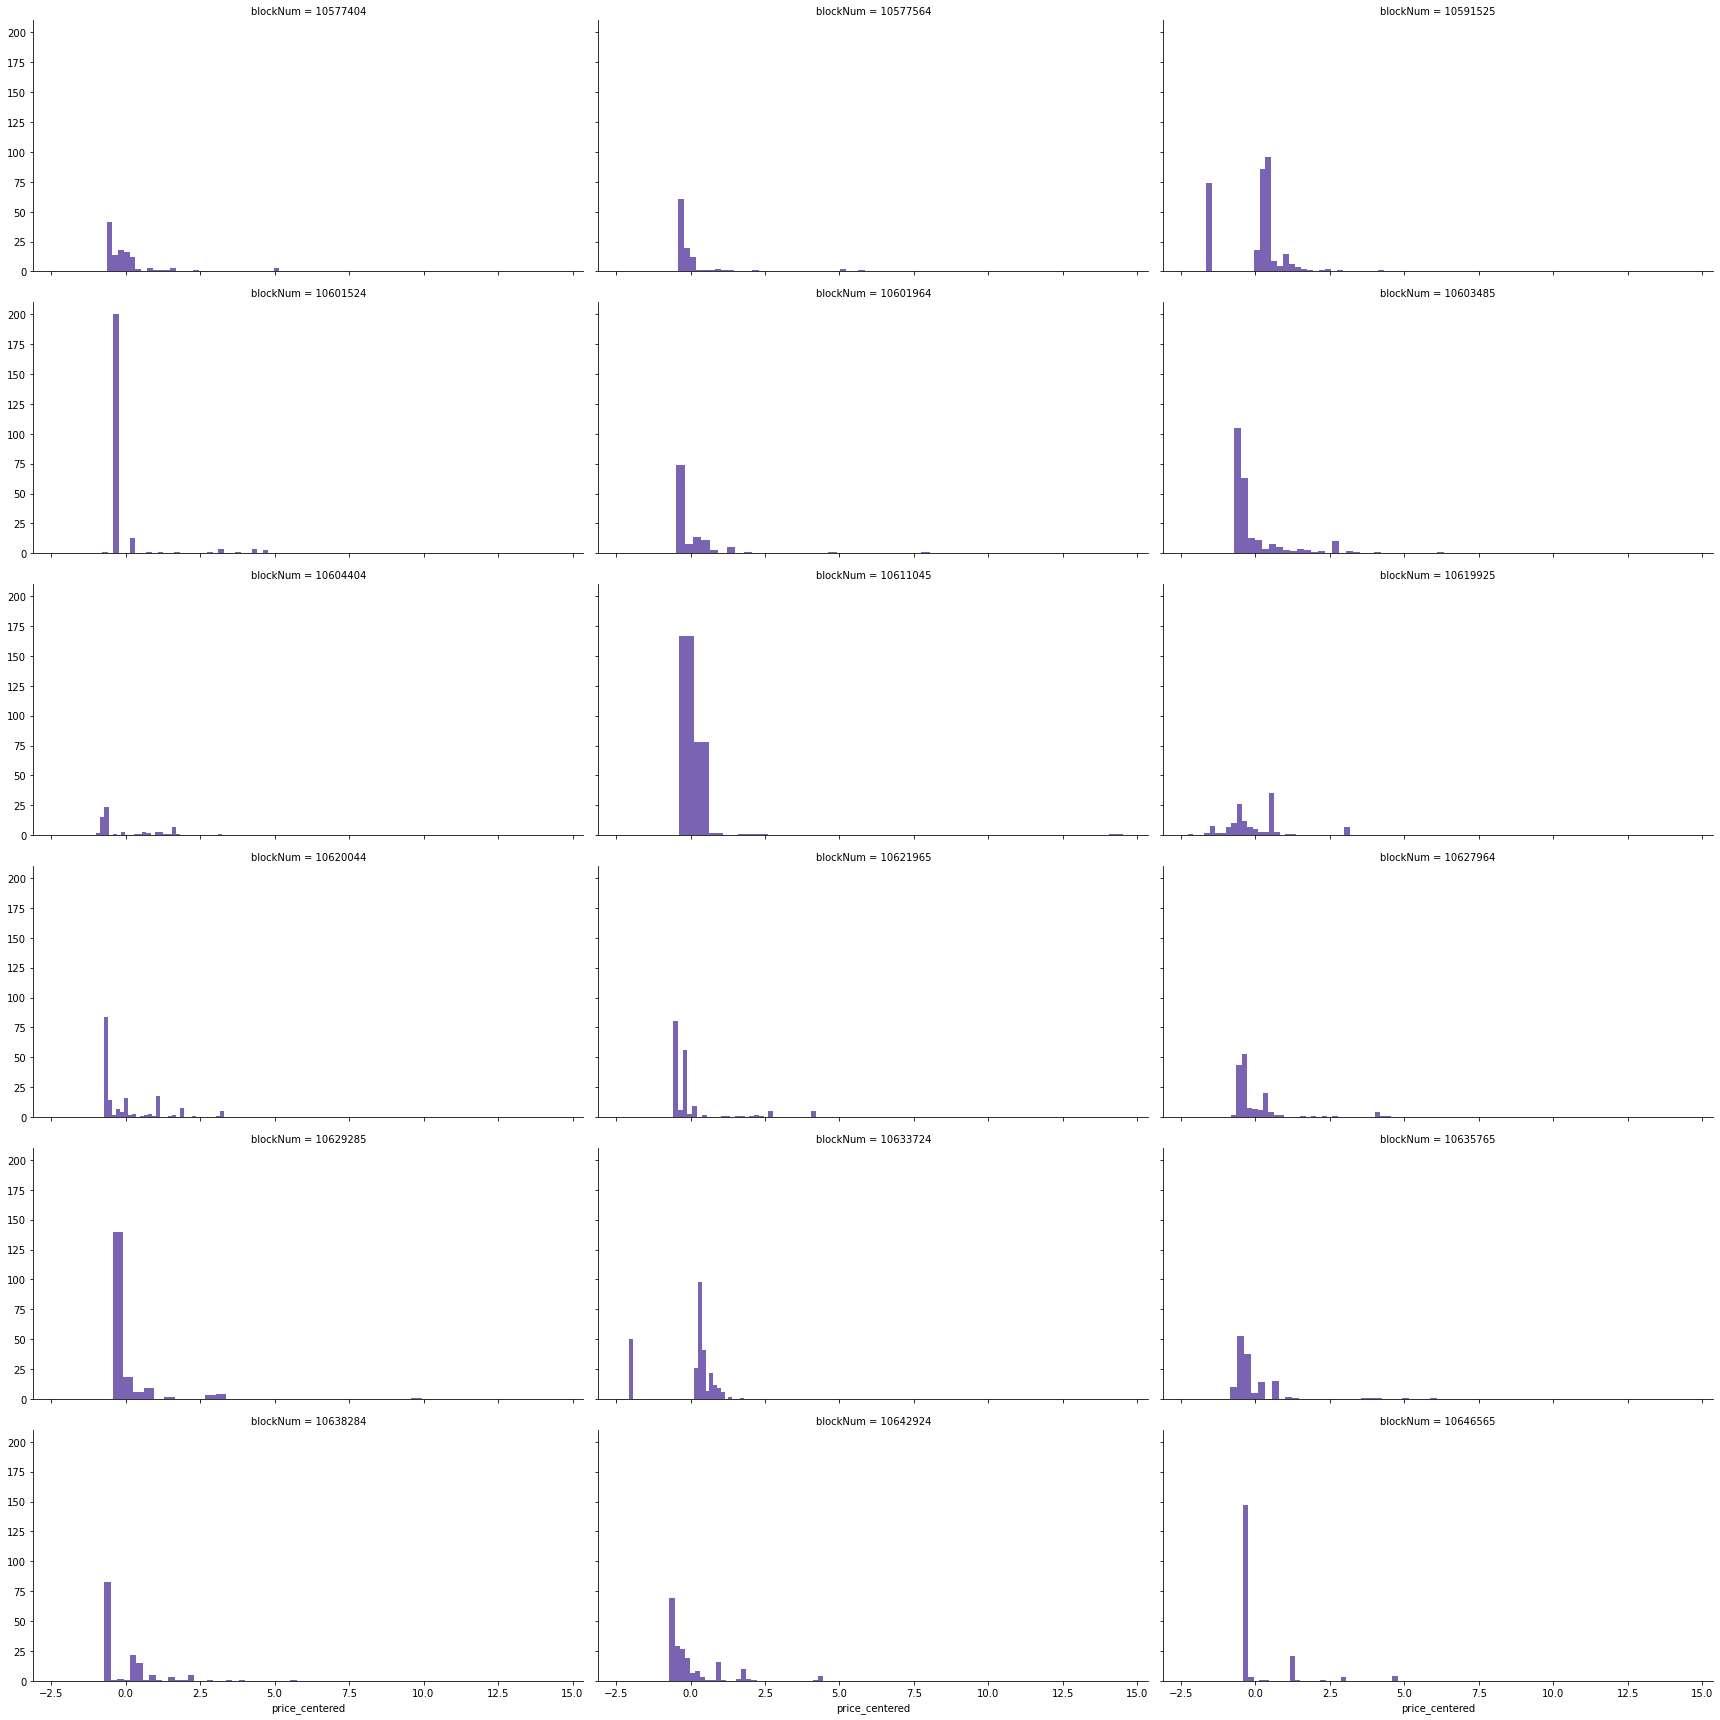

In [3]:
# randomly select blocks from the data
sample_n = 18
block_nums = random.sample(list(set(df['blockNum'])), sample_n)
df_sample = df[df.blockNum.isin(block_nums)]
# normalize
df_sample['price_centered'] = df_sample.groupby('blockNum')['gasPrice'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

g = sns.FacetGrid(df_sample, col="blockNum", col_wrap=3, height=4, aspect=2)
g.map(
    sns.distplot, "price_centered", rug=False,
    hist_kws=dict(alpha=1), **{'bins': 30, 'color': API3_PURPLE},
    kde=False
);

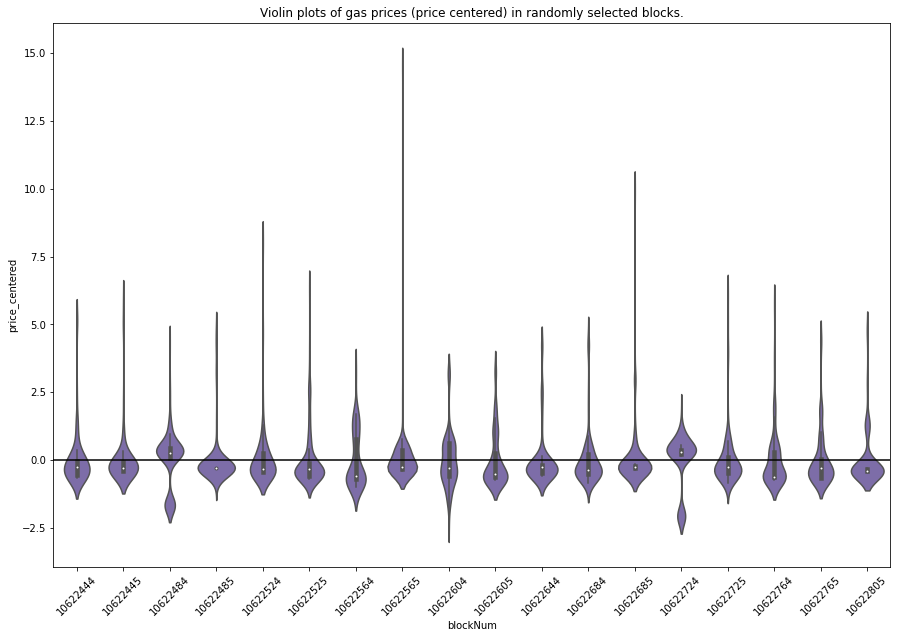

In [17]:
# violin plots to visually detect skewness
_, ax = plt.subplots(1, 1, figsize=(15,10))
g = sns.violinplot(
    ax=ax,
    x="blockNum",
    y="price_centered",
    height=1,
    aspect=1,
    color=API3_PURPLE,
    data=df_sample
)

g.set_title('Violin plots of gas prices (price centered) in randomly selected blocks.')

g.set_xticklabels(
    labels=df['blockNum'].unique(),
    fontdict={'fontsize': 10},
    rotation=45
);
ax = g.axes
ax.axhline(0, color='black');

## Comments
- There's clearly a strong right skew -- this makes sense: there's probably some frontrunning (or, less extreme, just people needing txns confirmed quickly) in each block which causes the right skew (towards higher gas prices)
- The mode tends to be around the lowest gas price in a block. This is more evident in the first set of plots.
    - This is potentially concerning to our analysis. Consider the mode being $x$ in block $B$, the minimum gas price in a block. I think this would imply that there are probably plenty of txns in the mempool that have that same gas price (consider: what are the chances that all txns in the mempool with gas price $x$ get mined in block $B$).
    - That is, I don't think we can assume having a txn with the minimum gas price mined in a given block implies it would get mined. A safer assumption would probably be having the gas price be *strictly* greater.
- I think there's a lot potentially to look at with the outliers/skew: for one thing, I wonder if the degree of skew is a predictor of increasing gas prices?

# Plotting gas prices of consecutive blocks

In [30]:
# mark consecutive pairs in some way
df['first'] = np.where(df['blockNum'] % 2 == 0, True, False)
df['pair'] = np.where(df['blockNum'] % 2 == 0, df['blockNum'], df['blockNum'] - 1)
df

,blockNum,txnID,gasPrice,is_greater_than_min_next_block,pair,first
0,10622444,0x889efe33c7d44428f01e45428eeb9362a9a1467e6865...,50.0,1.0,10622444,True
1,10622444,0xc3b15b99af8e163740cf9c5fe79b951f5018a04505c5...,150.0,1.0,10622444,True
2,10622444,0x32d3cffea7506342b88d5a309e23a1a85476d01bd8ad...,49.0,1.0,10622444,True
3,10622444,0x4e58f84e148781807fc7d685a08cb6412521bf8d7c47...,49.0,1.0,10622444,True
4,10622444,0xb407f9937fc7e95178bb90949af9e2ee1d63c871ae59...,49.0,1.0,10622444,True
...,...,...,...,...,...,...
747117,10624604,0xb739a8e730abbb66c4051e9a1252fa6d63523c34b13d...,58.0,0.0,10624604,True
747118,10624604,0x8918f37a6f76d8c063e1ecca1a421f5f6c4339539f55...,58.0,0.0,10624604,True
747119,10624604,0x44eab450a48c58c264da696224c78484e0ea169882c9...,58.0,0.0,10624604,True
747120,10624604,0xfcfaa1f10b194af458bf6adb31aac7280dabdbe4d62b...,58.0,0.0,10624604,True


In [38]:
df_sample

,blockNum,txnID,gasPrice,is_greater_than_min_next_block,pair,first
13403,10601524,0xc7fec50888d4c5c1f60768352a36e37755724abb44a7...,41.0,1.0,10601524,True
13404,10601524,0xc5847984627452b55f584d306248a0b02393e45d98fe...,39.0,1.0,10601524,True
13405,10601524,0x6a548a09ddb5c44d5c2cacc1f3bd41ef14032a137931...,40.0,1.0,10601524,True
13406,10601524,0xbc91d0946abeba6f49fa59f3756c5f7af3ae666aad06...,41.0,1.0,10601524,True
13407,10601524,0x047acc7631d7d1d349a651c29f16e8d5c4b1b6dcaaf3...,41.0,1.0,10601524,True
...,...,...,...,...,...,...
741351,10611045,0x4c6361830550817f60381c61aaa87eebf59b69198b7d...,56.0,NaN,10611044,False
741352,10611045,0x980e64d0741201df445173b0b61cfd145d361eea5f31...,56.0,NaN,10611044,False
741353,10611045,0xb3e6eb0585c8078a9efd8ace99deeca7796c125d2819...,56.0,NaN,10611044,False
741357,10611045,0xea49c6afd8ec78f8cc909cc12b5204eddf6d4d8aa9bb...,56.0,NaN,10611044,False


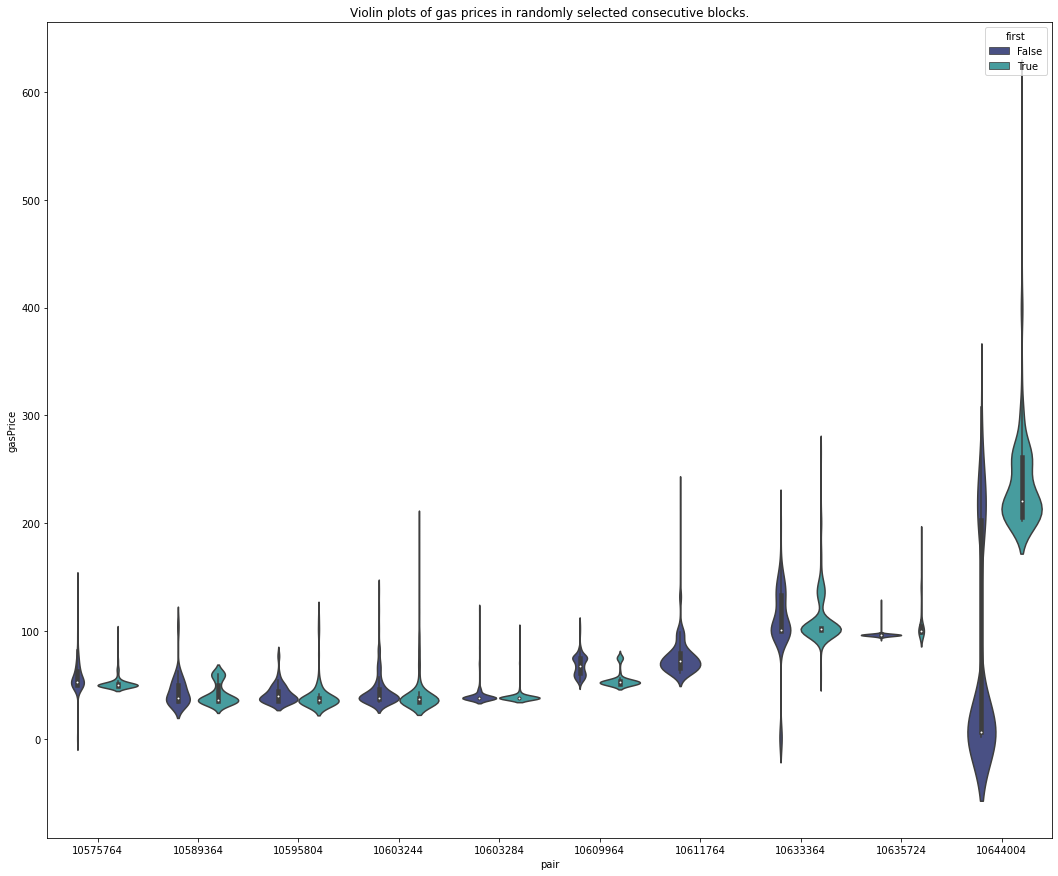

In [59]:
sample_n = 10
pairs = random.sample(list(set(df['pair'])), sample_n)
df_sample = df[df.pair.isin(pairs)]
# TODO: remove top ~3 txns from block to reduce sometimes giant tails

g, ax = plt.subplots(1, 1, figsize=(18,15))
sns.violinplot(x="pair", y="gasPrice", hue="first", data=df_sample, palette="mako");

ax.set_title('Violin plots of gas prices in randomly selected consecutive blocks.');

# How many of these transactions have a gas price greater than the min of the next block?

In [5]:
# get minimum gas price for each block
df_mins = df.groupby("blockNum", as_index=True)["gasPrice"].min()
df_mins

blockNum
10570484     45.1
10570485     45.0
10570524     44.0
10570525     45.0
10570564     41.0
            ...  
10651324    319.0
10651325    201.0
10651364    225.0
10651365      1.0
10651404    241.2
Name: gasPrice, Length: 3897, dtype: float64

In [6]:
def f(row):
    if row['blockNum'] + 1 not in df_mins.index:
        return np.nan
    elif row['gasPrice'] > df_mins.loc[row['blockNum'] + 1]:
        return 1
    else:
        return 0
    
df['is_greater_than_min_next_block'] = df.apply(f, axis=1)

In [7]:
df[df['is_greater_than_min_next_block'] == np.nan]

,blockNum,txnID,gasPrice,is_greater_than_min_next_block


In [8]:
res = df.groupby('is_greater_than_min_next_block').count()
res

,blockNum,txnID,gasPrice
is_greater_than_min_next_block,,,
0.0,55602,55602,55602
1.0,306092,306092,306092


In [9]:
# total proportion of all txns
res.loc[1].blockNum / (res.loc[0].blockNum + res.loc[1].blockNum)

0.8462733692015902

## What about distribution per block?
I.e. is there a lot of variability with this proportion block to block?

In [10]:
df_ = df.dropna()
print('total number of blocks:')
print(len(df_.blockNum.unique()))

total number of blocks:
1875


In [11]:
grouped = df_.groupby('blockNum').mean()
grouped

,gasPrice,is_greater_than_min_next_block
blockNum,,
10570484,68.802892,1.000000
10570524,51.215623,0.360731
10570604,55.907080,1.000000
10570644,61.264310,1.000000
10570684,47.645609,1.000000
...,...,...
10651204,247.129995,0.814815
10651244,260.164945,0.059829
10651284,361.882299,1.000000


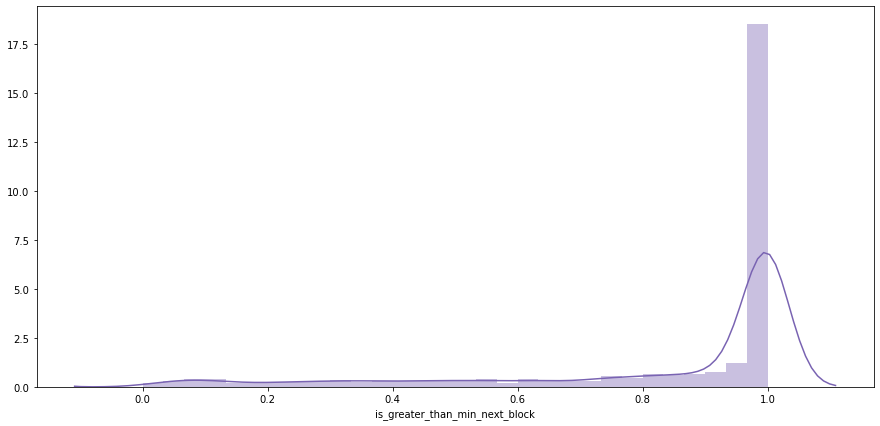

In [12]:
_, ax = plt.subplots(1, 1, figsize=(15,7))
sns.distplot(grouped["is_greater_than_min_next_block"], kde=True, **{'bins': 30, 'color': API3_PURPLE});

### How many blocks have *all* txns satsifying the condition?
where condition == the gas price is *strictly greater* than the min of the next block

In [13]:
(grouped["is_greater_than_min_next_block"] > 0.999).mean()

0.5082666666666666

### How many blocks have *none* of the txns satisifying the condition?

In [14]:
(grouped["is_greater_than_min_next_block"] <= 0.001).mean()

0.0005333333333333334

### How many blocks have *less than half* satisifying the condition?

In [15]:
(grouped["is_greater_than_min_next_block"] < 0.5).mean()

0.14506666666666668

## Comments:
This is kind of what I was expecting / worried about: *most* of the time this works fine (this == picking a random txn from block $x$, taking it's gas price, and having it be greater than the min of the next block). It's outlier conditions that are worrisome; e.g. those ~15% of blocks that have only 50% of txns satisfy the condition. This implies there's some analysis to be done on these outlier / long-tail scenerios.

### Quick test: is condition satisfication correlated to gas price?

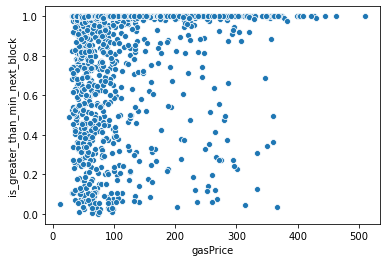

In [16]:
sns.scatterplot(data=grouped, x="gasPrice", y="is_greater_than_min_next_block");

Doesn't look like it. I was thinking maybe condition satisfaction was inversely correlated to gas price, but it doesn't seem to be the case. 

### TODO:
- Further analysis into those outlier cases / long-tail scenerios
- Analyze the assumption that having a gas price greater than the min in a given block is sufficient to get mined
- Analyze tradeoff in gas price selection mechanism: cost vs speed